### import packages

In [ ]:
from PIL import Image
import scipy.io
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
import skimage.io as skio
import cv2
from scipy import interpolate
from skimage import draw
import os
%cd /content/drive/MyDrive/cs180/project3

/content/drive/MyDrive/cs180/project3


## Part 1

###Cropping image ##

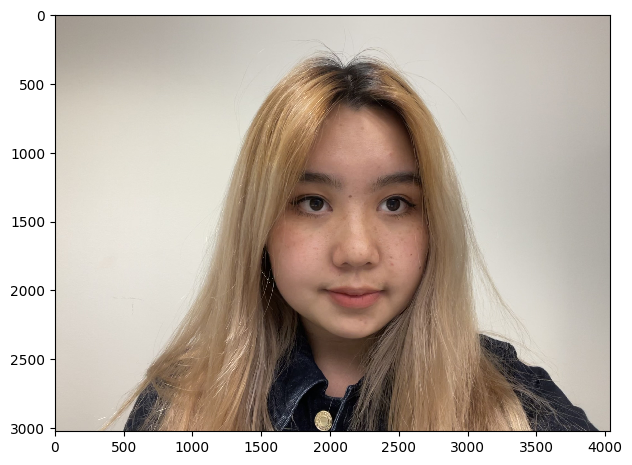

(3024, 4032, 3)


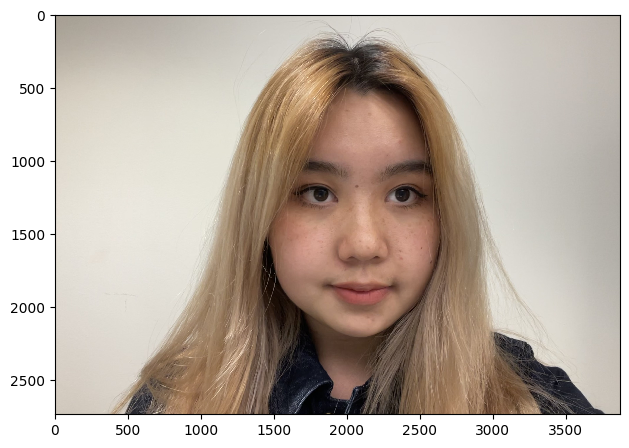

(2736, 3872, 3)


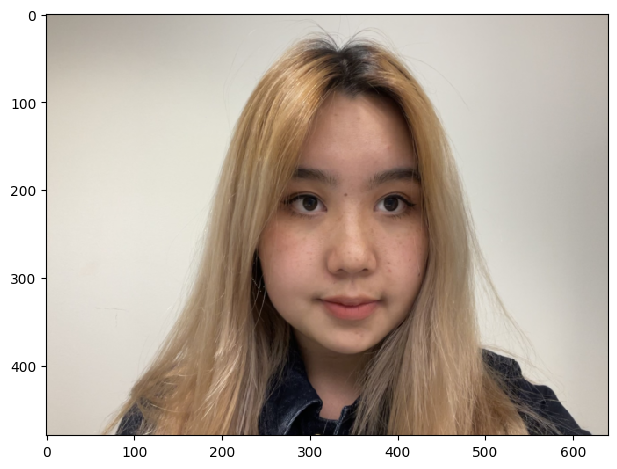

(480, 640, 3)


In [ ]:
from skimage.transform import rescale, resize, downscale_local_mean
me = skio.imread('me.jpeg')
skio.imshow(me)
skio.show()
print(me.shape)

hattie = skio.imread('hattie.jpeg')

cropped_me = me[280:2600, 1000:3320]


target_size = (512, 512)

# Resize the image to the target size
resized_image = resize(cropped_me, target_size, anti_aliasing=True)
resized_image = (resized_image* 255).astype(np.uint8)

part_4_target_size = (480,640)
cropped_me_2 = me[144:-144, 80:-80]
skio.imshow(cropped_me_2)
skio.show()
print(cropped_me_2.shape)

resized_image_2 = resize(cropped_me_2, part_4_target_size, anti_aliasing=True)
resized_image_2 = (resized_image_2* 255).astype(np.uint8)
skio.imshow(resized_image_2)
skio.show()
print(resized_image_2.shape)
skio.imsave('resized_cropped_me_2.jpg', resized_image_2)

### use matlab to extract correspondances

In [ ]:
#use matlab to choose correspondance point:
#code:
# imageA = imread('mark-2.jpg');
# imageB = imread('musk.jpeg');
# cpselect(imageA, imageB);
# save('correspondences.mat', 'base_points', 'input_points');

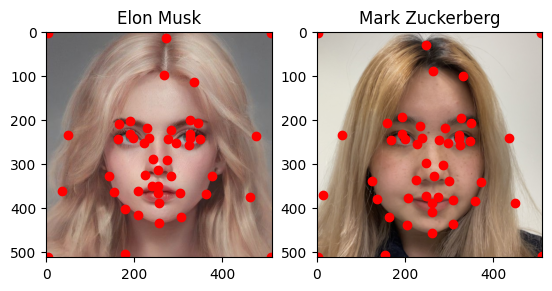

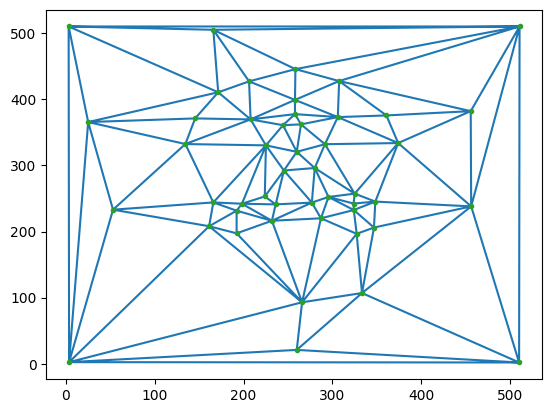

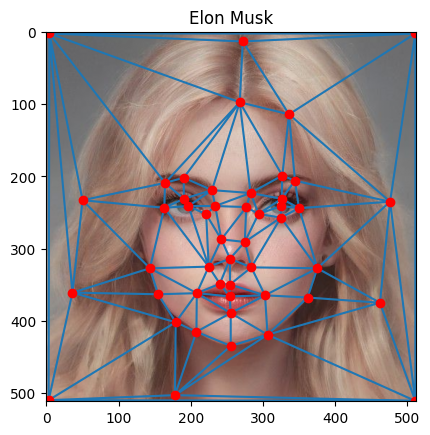

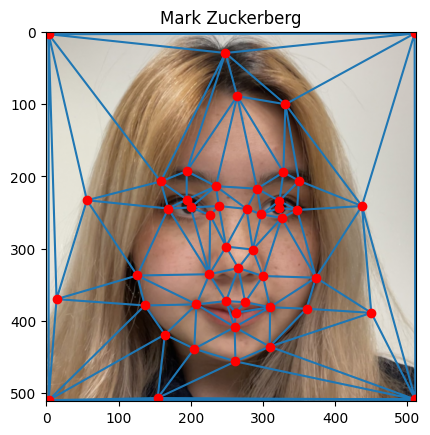

In [ ]:
# read two target images, musk and mark (3-d numpy array)

# musk = skio.imread("musk.jpeg")
# musk = sk.img_as_float(musk)
# mark = skio.imread("mark.jpg")
# mark = sk.img_as_float(mark)
mark = sk.img_as_float(resized_image)
musk = sk.img_as_float(hattie)
# load correpondence mat produced from matlab
# mat_contents = scipy.io.loadmat('correspondences-4.mat')
mat_contents = scipy.io.loadmat('correspondences-5.mat')
# Access the correspondence data for musk and mark, and midway_shape (50,2)
# musk_points = mat_contents['muskPoints']
# mark_points = mat_contents['markPoints']
musk_points = mat_contents['hattiePoints']
mark_points = mat_contents['mePoints']
midway_shape = (musk_points + mark_points) / 2

# use Delaunay to produce triangulation
musk_triangulation = Delaunay(musk_points)
mark_triangulation = Delaunay(mark_points)
triangulation = Delaunay(midway_shape)

# visualize it
plt.subplot(1, 2, 1)
plt.imshow(musk)
plt.plot(musk_points[:, 0], musk_points[:, 1], 'ro')  # Red points
plt.title("Elon Musk")

plt.subplot(1, 2, 2)
plt.imshow(mark)
plt.plot(mark_points[:, 0], mark_points[:, 1], 'ro')  # Red points
plt.title("Mark Zuckerberg")
plt.show()

plt.triplot(midway_shape[:, 0], midway_shape[:, 1], triangulation.simplices)
plt.plot(midway_shape[:, 0], midway_shape[:, 1], 'o', markersize=3)
plt.show()

# Plot the Delaunay triangulation for Musk's image
plt.imshow(musk)
plt.triplot(musk_points[:, 0], musk_points[:, 1], musk_triangulation.simplices)
plt.plot(musk_points[:, 0], musk_points[:, 1], 'ro')  # Red points
plt.title("Elon Musk")

# Show the plot
plt.show()

# Plot the Delaunay triangulation for mark's image
plt.imshow(mark)
plt.triplot(mark_points[:, 0], mark_points[:, 1], mark_triangulation.simplices)
plt.plot(mark_points[:, 0], mark_points[:, 1], 'ro')  # Red points
plt.title("Mark Zuckerberg")

# Show the plot
plt.show()


## Part 2

In [ ]:
def computeAffine(tri1_pts, tri2_pts):
    # reformat source and destination triangles as 3x2 arrays
    src = tri1_pts.T
    dst = tri2_pts.T

    ## Ax = b ==> Axx^-1 = bx^-1 ==> A = b*x^-1
    x = np.vstack((src, np.ones(src.shape[1])))
    b = np.vstack((dst, np.ones(dst.shape[1])))
    A = np.matmul(b, np.linalg.inv(x))
    return A

# warp from imageA/B to midway image
# inputs are the x,y indicies of source triangle, x,y indicies of destination triangle, source image, destination image
def warp(old_indicies, new_indicies, old_image, new_image):
  # old_indicies are the indicies of three points in source triangle,
  # in the format of [[r1,c1],[r2,c2],[r3,c3]]

  ## old_indicies[:0]->rows, old_indicies[:,1]-> cols
  # mask for the triangle of source image
  old_polygon = draw.polygon(old_indicies[:,0], old_indicies[:,1]) ## polygon

  # retrieve the pixels value of the mask from the old image
  old_pixels = old_image[old_polygon[::-1]] ## row, col -> col, row

  # mask for the triangle of destination image
  new_polygon = draw.polygon(new_indicies[:,0], new_indicies[:,1])
  # new_polygon = draw.polygon(new_indicies[:,1], new_indicies[:,0])

  # compute the transformation matrix from source image to destination image
  A = computeAffine(old_indicies, new_indicies)
  # find the inverse of it
  inv_A =np.linalg.inv(A)

  # use the inverse affine function to find the corresponding indicies of midway face in source image
  # new_polygon[0]->row
  b = np.vstack((new_polygon[0], new_polygon[1],np.ones(len(new_polygon[0]))))
  dest_indicies = (inv_A @ b)[:2] # computation, get rid of the ones
  # interpolation, takes in points indicies, points values, 2-d array of points to interpolate
  new_pixels = interpolate.griddata(old_polygon, old_pixels, (dest_indicies[0], dest_indicies[1]), method='nearest')
  new_pixels = np.clip(new_pixels, 0, 1) # clip the values to 0 and 1
  # change the old values to the new values at the given row, columns.
  new_image[new_polygon[1], new_polygon[0]] = new_pixels ## row, col -> col, row

  #new_image[new_polygon[0], new_polygon[1]] = new_pixels
def midway_morph(image1, image2, img1points, img2points, midwaytriangulation):
  # create two canvases to put the later generated faces on....
  new_1 = np.zeros_like(image1)
  new_2 = np.zeros_like(image2)
  # iterate through each triangle
  for i in midwaytriangulation.simplices:
    # get the x,y indicies from two source images
    img1_indicies = img1points[i]
    img2_indicies = img2points[i]
    # get the x,y indicies from destination images
    midway_indicies = midway_shape[i]
    # updating the cavas through warping
    warp(img1_indicies,midway_indicies,image1,new_1)

    warp(img2_indicies,midway_indicies,image2,new_2)
  return new_1, new_2

In [ ]:
# im1 = mark
# im2 = musk
# im1_pts = mark_points
# im2_pts = musk_points
# midway_indicies = (im1_pts + im2_pts)/2
# dissolve_frac = 0.9
# new_im1 = im1.copy()
# new_im2 = im2.copy()
# for i in triangulation.simplices:
#   img1_indicies = im1_pts[i]
#   img2_indicies = im2_pts[i]
#   warp(img1_indicies,midway_indicies,im1,new_im1)
#   warp(img2_indicies,midway_indicies,im2,new_im2)

# final_imag = new_im1 * dissolve_frac + (1 - dissolve_frac) * new_im2
# skio.imshow(new_im1)
# skio.show()
# skio.imshow(new_im2)
# skio.show()
# skio.imshow(new_im1 * 0.5 + new_im2*0.5)
# skio.show()

(3, 60) (3, 3)


ValueError: ignored

## Part 3



**morphed_im = morph(im1, im2, im1_pts, im2_pts, tri, warp_frac, dissolve_frac);**

that produces a warp between im1 and im2 using point correspondences defined in im1_pts and im2_pts (which are both n-by-2 matrices of (x,y) locations) and the triangulation structure tri . The parameters warp_frac and dissolve_frac control shape warping and cross-dissolve, respectively. In particular, images im1 and im2 are first warped into an intermediate shape configuration controlled by warp_frac, and then cross-dissolved according to dissolve_frac. For interpolation, both parameters lie in the range [0,1]. They are the only parameters that will vary from frame to frame in the animation. For your starting frame, they will both equal 0, and for your ending frame, they will both equal 1.

In [ ]:
# similar to midway_morph, added dissolve_frac
def morph(im1, im2, im1_pts, im2_pts, tri, warp_frac, dissolve_frac):
  warp_pts = im1_pts * warp_frac + im2_pts * (1 - warp_frac)
  new_im1 = im1.copy()
  new_im2 = im2.copy()
  for i in tri.simplices:
    img1_indicies = im1_pts[i]
    img2_indicies = im2_pts[i]
    midway_indicies = warp_pts[i]
    warp(img1_indicies,midway_indicies,im1,new_im1)
    warp(img2_indicies,midway_indicies,im2,new_im2)
  final_imag = new_im1 * dissolve_frac + (1 - dissolve_frac) * new_im2
  return final_imag

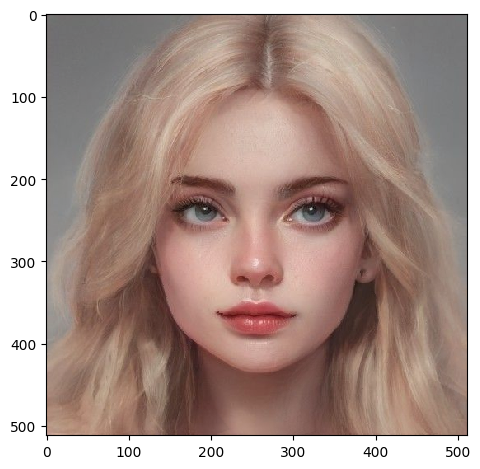

<class 'numpy.ndarray'>


In [ ]:
half_mark_musk = morph(mark, musk, mark_points, musk_points, triangulation, 0.1, 0.1)
skio.imshow(half_mark_musk)
skio.show()



print(type(half_mark_musk))

In [ ]:
frame = []
points = np.linspace(0, 1, 50)
for p in points:
  image = morph(mark, musk, mark_points, musk_points, triangulation, p, p)
  image = (image* 255).astype(np.uint8)
  skio.imshow(image)
  skio.show()
  frame.append(image)
  filename = "part_3/part_3_" + str(p) + ".jpg"
  skio.imsave(filename, image)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from PIL import Image
# List of image files
image_files = os.listdir('part_3/')
print(image_files)

images = []

# Load each image and append it to the list
for file in image_files[::-1]:
    img = Image.open('part_3/' + file)
    images.append(img)

images[0].save('output.gif', save_all=True, append_images=images[1:], duration=70, loop=0)

['part_3_0.0.jpg', 'part_3_0.02040816326530612.jpg', 'part_3_0.04081632653061224.jpg', 'part_3_0.061224489795918366.jpg', 'part_3_0.08163265306122448.jpg', 'part_3_0.1020408163265306.jpg', 'part_3_0.12244897959183673.jpg', 'part_3_0.14285714285714285.jpg', 'part_3_0.16326530612244897.jpg', 'part_3_0.18367346938775508.jpg', 'part_3_0.2040816326530612.jpg', 'part_3_0.22448979591836732.jpg', 'part_3_0.24489795918367346.jpg', 'part_3_0.26530612244897955.jpg', 'part_3_0.2857142857142857.jpg', 'part_3_0.3061224489795918.jpg', 'part_3_0.32653061224489793.jpg', 'part_3_0.3469387755102041.jpg', 'part_3_0.36734693877551017.jpg', 'part_3_0.3877551020408163.jpg', 'part_3_0.4081632653061224.jpg', 'part_3_0.42857142857142855.jpg', 'part_3_0.44897959183673464.jpg', 'part_3_0.4693877551020408.jpg', 'part_3_0.4897959183673469.jpg', 'part_3_0.5102040816326531.jpg', 'part_3_0.5306122448979591.jpg', 'part_3_0.5510204081632653.jpg', 'part_3_0.5714285714285714.jpg', 'part_3_0.5918367346938775.jpg', 'part_3_

## Part 4 The "Mean face" of a population


In [ ]:

import pandas as pd

def read_asf(file_path):
  data = []
  n = 0
  filename = ''
  # Open the ASF file for reading
  with open(file_path, 'r') as asf_file:
      # Read and process the file line by line
      for line in asf_file:
          # Remove leading and trailing whitespace and ignore empty lines
          line = line.strip()
          if not line:
              continue
          # Ignore comment lines starting with '#' character
          if line.startswith('#'):
              continue

          else:
            line = line.split('\t')
            if len(line) == 1 and n == 0:
              n = int(line[0])
              continue

            try:
                data_entry = [float(x) for x in line]
                data.append(data_entry)

            except:
              filename = line
  return np.array(data)

file_path = 'imm_face_db/01-1m.asf'
data = read_asf(file_path)

# <path#> <type> <x-pos> <y-pos> <point#> <connects from> <connects to>
# example: [0.0, 4.0, 0.35763609, 0.64077979, 0.0, 0.0, 1.0]

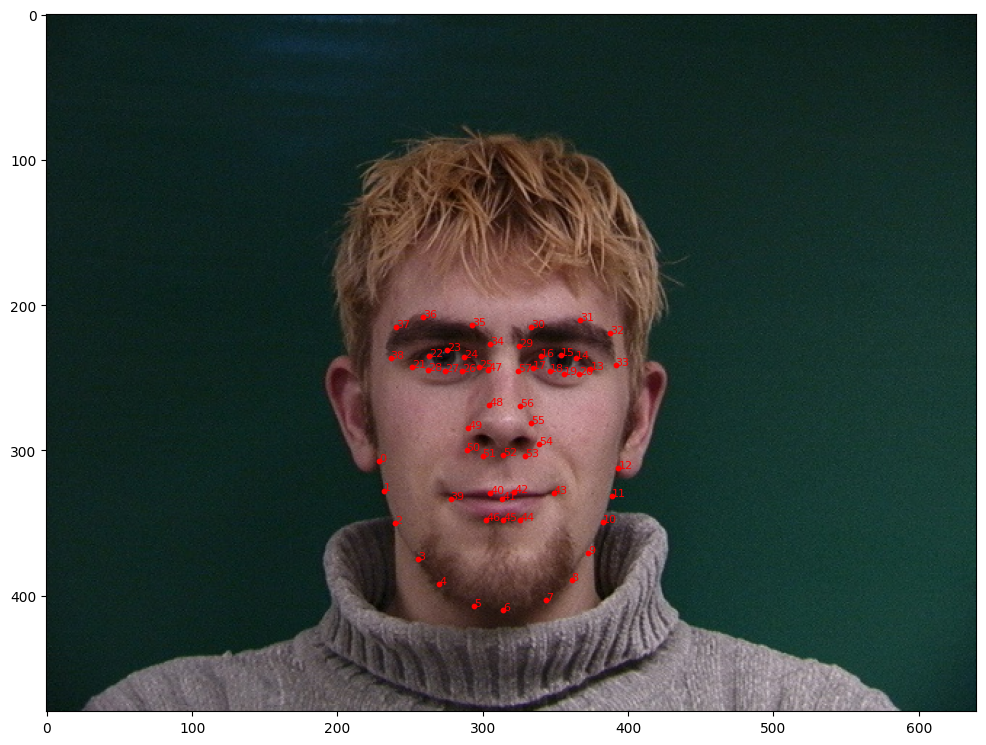

58


In [ ]:
## take a look at their points

import matplotlib.pyplot as plt
import numpy as np

face_image = plt.imread('imm_face_db/01-1m.jpg')


x_coords = data[:,2] * 640
y_coords = data[:,3] * 480
point_numbers = data[:,4]

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(face_image)

for i in range(len(point_numbers)):
    plt.text(x_coords[i], y_coords[i], str(int(point_numbers[i])), color='red', fontsize=8)
    plt.scatter(x_coords[i], y_coords[i], c='red', s=10)
plt.savefig('example.jpg', format = 'jpeg')
plt.show()
print(len(x_coords))


In [ ]:
# get my corresponding points
import json
file_pt = 'me2.json'
with open(file_pt, 'r') as json_file:
    data = json.load(json_file)
my_points_2 = data['im1Points']
my_points_2 = np.vstack((my_points_2, np.array([[0.5,0.5],[639.5,0.5],[0.5,479.5],[639.5,479.5]])))


In [ ]:
# create dataset

# the corner of the image
corners = np.array([[0.5,0.5],[639.5,0.5],[0.5,479.5],[639.5,479.5]])
width = 640
height = 480

def populate_male_dataset():
    imm_dataset = {}
    points_list = []
    imm_directory = os.listdir('imm_face_db')
    # iterate through each -1m asf file
    for asf_file in imm_directory:
      if asf_file.endswith('-1m.asf'):
        # these are the front faces we want!!!
        file_number = asf_file.split('-')[0]
        file_data = read_asf(os.path.join('imm_face_db', asf_file))

        # prepare points
        x_coordinate = file_data[:, 2] * width
        y_coordinate = file_data[:,3] * height
        coordinates = np.column_stack([x_coordinate, y_coordinate])
        coordinates = np.vstack((coordinates, corners))

        #add it to dataset and the list
        imm_dataset[file_number] = coordinates
        points_list.append(coordinates)

    mean_face_points = np.mean(points_list, axis=0)
    return imm_dataset, mean_face_points

def populate_female_dataset():
    imm_dataset = {}
    points_list = []
    imm_directory = os.listdir('imm_face_db')
    # iterate through each -1m asf file
    for asf_file in imm_directory:
      if asf_file.endswith('-1f.asf'):
        # these are the front faces we want!!!
        file_number = asf_file.split('-')[0]
        file_data = read_asf(os.path.join('imm_face_db', asf_file))

        # prepare points
        x_coordinate = file_data[:, 2] * width
        y_coordinate = file_data[:,3] * height
        coordinates = np.column_stack([x_coordinate, y_coordinate])
        coordinates = np.vstack((coordinates, corners))

        #add it to dataset and the list
        imm_dataset[file_number] = coordinates
        points_list.append(coordinates)

    mean_face_points = np.mean(points_list, axis=0)
    return imm_dataset, mean_face_points
def populate_dataset():
  imm_dataset = {}
  points_list = []
  imm_directory = os.listdir('imm_face_db')
  # iterate through each asf file
  for asf_file in imm_directory:

    if asf_file.endswith('-1f.asf') or asf_file.endswith('-1m.asf'):
      # these are the front faces we want!!!
      file_number = asf_file.split('.')[0]
      file_data = read_asf(os.path.join('imm_face_db', asf_file))

      # prepare points
      x_coordinate = file_data[:, 2] * width
      y_coordinate = file_data[:,3] * height
      coordinates = np.column_stack([x_coordinate, y_coordinate])
      coordinates = np.vstack((coordinates, corners))

      #add it to dataset and the list
      imm_dataset[file_number] = coordinates
      points_list.append(coordinates)

    mean_face_points = np.mean(points_list, axis=0)
  return imm_dataset, mean_face_points
male_dataset, male_mean_face_points = populate_male_dataset()
female_dataset, female_mean_face_points = populate_female_dataset()
whole_dataset, whole_mean_face_points = populate_dataset()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
## warp images towards the mean face
# gender specific
def warp_to_mean(file_num, dataset, mean_face_points,gender):
  mean_delaunay = Delaunay(mean_face_points)
  image = sk.img_as_float(skio.imread('imm_face_db/' + file_num + '-1'+gender+'.jpg'))
  coordinates = dataset[file_num]
  warped_face = morph(image, image, coordinates, mean_face_points, mean_delaunay, 0, 1)
  return warped_face
# whole population
def warp_to_mean_population(file_num, dataset, mean_face_points):
  mean_delaunay = Delaunay(mean_face_points)
  image = sk.img_as_float(skio.imread('imm_face_db/' + file_num +'.jpg'))
  coordinates = dataset[file_num]
  warped_face = morph(image, image, coordinates, mean_face_points, mean_delaunay, 0, 1)
  return warped_face

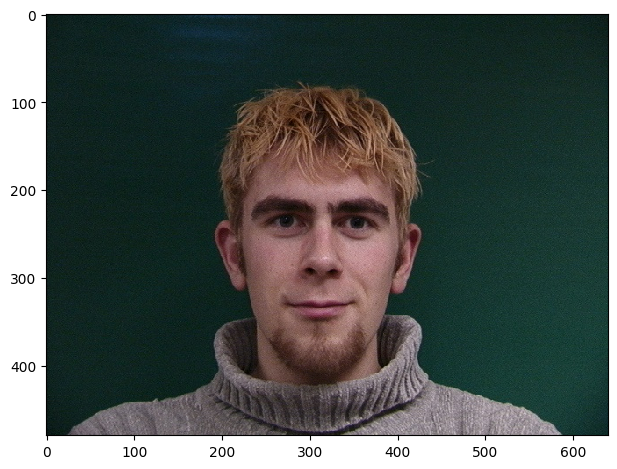

im before final_image


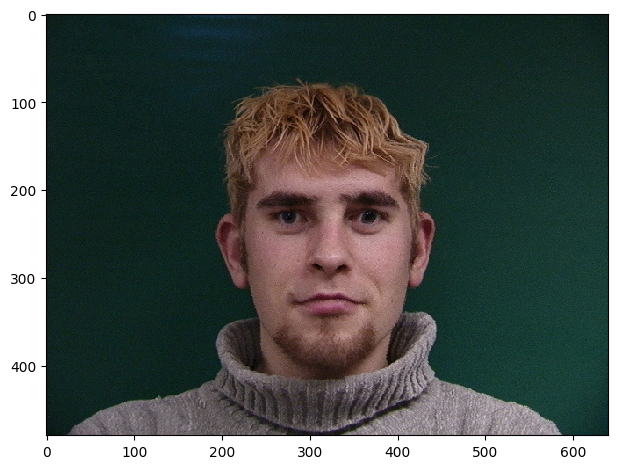

In [ ]:
# testing out function:
image = sk.img_as_float(skio.imread('imm_face_db/' + '01' + '-1m.jpg'))
skio.imshow(image)
skio.show()

male_warped_face = warp_to_mean('01',male_dataset, male_mean_face_points,'m')
skio.imshow(male_warped_face)
skio.show()

In [ ]:
male_mean_face_dataset = []
gray = ['02','03','04','21']
for file_num in male_dataset.keys():
  print(file_num)
  if file_num not in gray:
    skio.imshow('imm_face_db/' + file_num + '-1m.jpg')
    skio.show()
    mean_face = warp_to_mean(file_num,male_dataset, male_mean_face_points,'m')
    skio.imshow(mean_face)
    skio.show()
    male_mean_face_dataset.append(mean_face)
    # mean_face = (mean_face* 255).astype(np.uint8)
    # skio.imsave('male_mean_faces/' + file_num + '_averaged.jpg', mean_face)



Output hidden; open in https://colab.research.google.com to view.

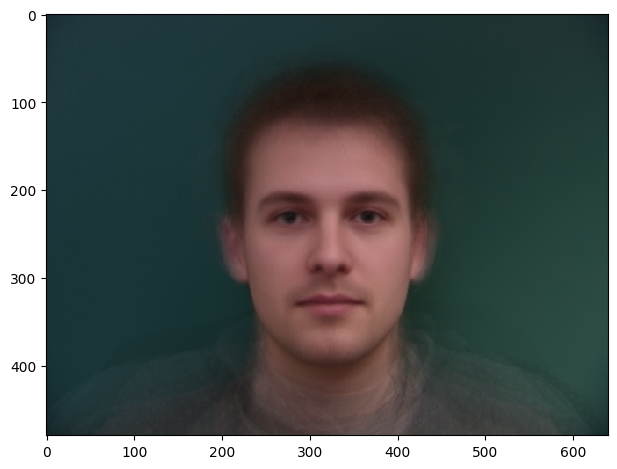

In [ ]:
mean_male_face = sum(male_mean_face_dataset)/len(male_mean_face_dataset)
skio.imshow(mean_male_face)
skio.show()
mean_male_face = (mean_male_face * 255).astype(np.uint8)
skio.imsave('male_mean_faces/average_male_face.jpg', mean_male_face)

In [ ]:
female_mean_face_dataset = []
for file_num in female_dataset.keys():
  print(file_num)
  mean_face = warp_to_mean(file_num,female_dataset, female_mean_face_points,'f' )
  female_mean_face_dataset.append(mean_face)
  mean_face = (mean_face* 255).astype(np.uint8)
  skio.imsave('female_mean_faces/' + file_num + '_averaged.jpg', mean_face)


08
12
15
14
22
30
35


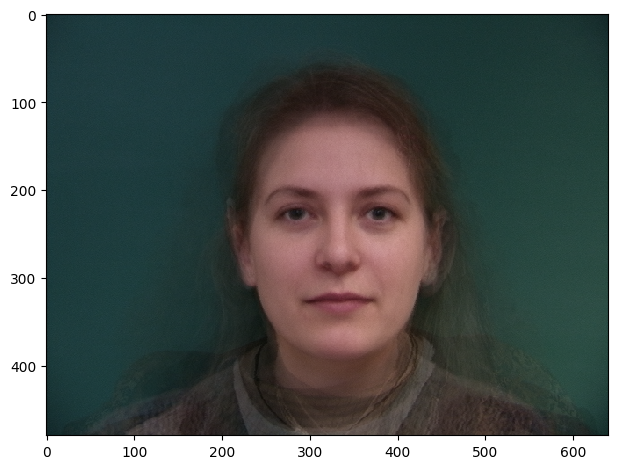

In [ ]:
mean_female_face = sum(female_mean_face_dataset)/len(female_mean_face_dataset)
mean_female_face = (mean_female_face* 255).astype(np.uint8)
skio.imsave('female_mean_faces/average_female_face.jpg', mean_female_face)
skio.imshow(mean_female_face)
skio.show()

In [ ]:
whole_mean_face_dataset = []
gray = ['02-1m','03-1m','04-1m','21-1m']
for file_num in whole_dataset.keys():
  print(file_num)
  if file_num not in gray:
    mean_face = warp_to_mean_population(file_num,whole_dataset, whole_mean_face_points)
    skio.imshow(mean_face)
    skio.show()
    whole_mean_face_dataset.append(mean_face)
    mean_face = (mean_face* 255).astype(np.uint8)
    skio.imsave('neutral_mean_faces/' + file_num + '.jpg', mean_face)


Output hidden; open in https://colab.research.google.com to view.

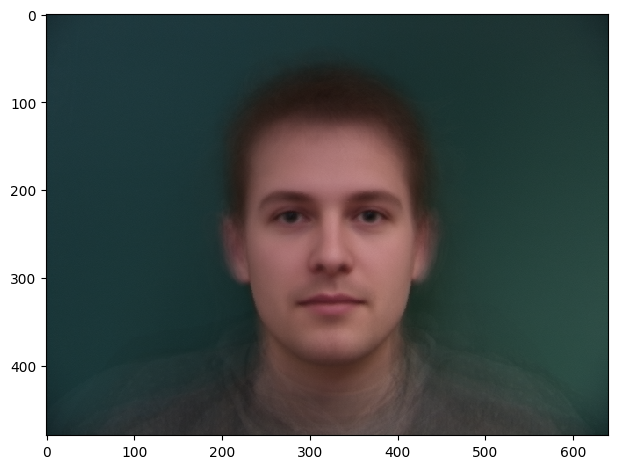

In [ ]:
mean_face = sum(whole_mean_face_dataset)/len(whole_mean_face_dataset)
skio.imshow(mean_face)
skio.show()
mean_face = (mean_face* 255).astype(np.uint8)
skio.imsave('neutral_mean_faces/average_face.jpg', mean_face)


In [ ]:
#  1) your face warped into the average geometry,
resized_image_2 = sk.img_as_float(resized_image_2)

me_to_mean = morph(resized_image_2, resized_image_2, my_points_2, whole_mean_face_points, Delaunay(whole_mean_face_points),0,1 )
skio.imshow(me_to_mean)
skio.show()
me_to_mean = (me_to_mean * 255).astype(np.uint)
skio.imsave('my_faces/me_to_mean.jpg')
# and 2) the average face warped into your geometry.
mean_to_me = morph(mean_face, mean_face, whole_mean_face_points, my_points_2, Delaunay(whole_mean_face_points),0,1 )
skio.imshow(mean_to_me)
skio.show()
mean_to_me = (mean_to_me * 255).astype(np.uint)
skio.imsave('my_faces/mean_to_me.jpg')



## Part 5


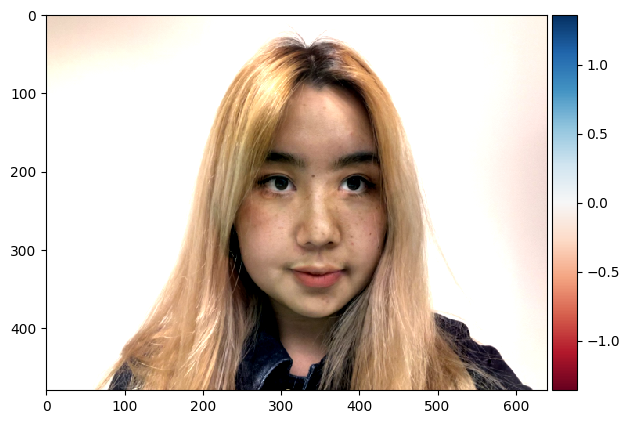

In [ ]:
character = resized_image_2 - mean_female_face
interpolated_me = resized_image_2 + character * 0.5
skio.imshow(interpolated_me)
skio.show()

## Bells and Whistles

In [ ]:
# change gender
# Change age/gender/ethnicity/smile/etc of your (or your friend's) face. You can use average images off the web for this, no need to recompute the averages yourself (unless you want to). Show morphing just the shape, just the appearance, and both.
male_characters = male_mean_face_points - female_mean_face_points
male_me = morph(resized_image_2, resized_image_2, my_points_2, my_points_2+male_characters, Delaunay(whole_mean_face_points), 0, 1)
skio.imshow(male_me)
skio.show()

NameError: ignored

In [46]:
## short video of the face in dataset....
all_frames = []
i = 0
j = 1
count = 0
list_of_files = list(whole_dataset.keys())

dane = Delaunay(whole_mean_face_points)
points = np.linspace(0, 1, 35)[::-1]
while j < len(list_of_files):
  name1 = list_of_files[i]
  name2 = list_of_files[j]
  img1 = skio.imread('imm_face_db/'+name1+'.jpg')
  img1 = sk.img_as_float(img1)
  img2 = skio.imread('imm_face_db/'+name2+'.jpg')

  img2 = sk.img_as_float(img2)
  img1_points = whole_dataset[name1]
  img2_points = whole_dataset[name2]
  for p in points:
    image = morph(img1, img2, img1_points, img2_points, dane, p, p)
    image = (image* 255).astype(np.uint8)
    skio.imshow(image)
    skio.show()
    all_frames.append(image)
    filename = "bells/" + str(count) + ".jpg"
    skio.imsave(filename, image)
    count += 1
  i += 1
  j += 1
  # points = points[::-1]

# not_in_loop = ['02-1m','03-1m','04-1m','21-1m']
# dane = Delaunay(whole_mean_face_points)
# for file_num in whole_dataset.keys():
#   print(file_num)
#   if file_num not in not_in_loop:
#     img1 = skio.imread('imm_face_db/'+curr+'.jpg')
#     img1 = sk.img_as_float(img1)
#     img2 = skio.imread('imm_face_db/'+file_num+'.jpg')
#     img2 = sk.img_as_float(img2)
#     img1_points = whole_dataset[curr]
#     img2_points = whole_dataset[file_num]
#     curr = file_num
#     points = np.linspace(0, 1, 30)
#     for p in points:
#       image = morph(img1, img2, img1_points, img2_points, dane, p, p)
#       image = (image* 255).astype(np.uint8)
#       skio.imshow(image)
#       skio.show()
#       all_frames.append(image)
#       filename = "bells/" + str(i) + ".jpg"
#       skio.imsave(filename, image)
#       i += 1
#   #   mean_face = warp_to_mean_population(file_num,whole_dataset, whole_mean_face_points)
#   #   skio.imshow(mean_face)
#   #   skio.show()
#   #   whole_mean_face_dataset.append(mean_face)

Output hidden; open in https://colab.research.google.com to view.

In [47]:
print(len(all_frames))

630


In [ ]:
# from PIL import Image
# # List of image files
# image_files = os.listdir('part_3/')
# print(image_files)

# images = []

# # Load each image and append it to the list
# for file in part_3:
#     img = Image.open('part_3/' + file)
#     images.append(img)

all_frames[0].save('output.gif', save_all=True, append_images=all_frames[1:], duration=1000, loop=0)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Custom TB Handler failed, unregistering
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-48-0caf8b894272>", line 13, in <cell line: 13>
    all_frames[0].save('all_faces_morphing.gif', save_all=True, append_images=all_frames[1:], duration=1000, loop=0)
AttributeError: 'numpy.ndarray' object has no attribute 'save'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 248, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 281, in _fixed_getinnerframes
    records = fix_frame_records_filenam